In [11]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import json 
from torch.utils.data import Dataset, DataLoader
from PIL import Image 
import clip 
from torchvision import transforms
from tqdm import tqdm
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
model ,p = clip.load('RN50')

In [ ]:
model.en

In [2]:


config = {
    # Data Paths
    'train_path' : '../../data/way_splits/train_data.json',
    'valid_seen_path' : '../../data/way_splits/valSeen_data.json',
    'valid_unseen_path': '../../data/way_splits/valUnseen_data.json',
    'mesh2meters': '../../data/floorplans/pix2meshDistance.json',
    'image_dir': '../../data/floorplans/',

    'device': 'cpu',

    # Hyper Parameters
    'max_floors': 5,

    # Image Parameters 
    'image_size': [3, 224, 224],
    'original_image_size': [3, 700, 1200],
    
}

In [3]:
class utils:
    class DotDict(dict):
        """
        a dictionary that supports dot notation 
        as well as dictionary access notation 
        usage: d = DotDict() or d = DotDict({'val1':'first'})
        set attributes: d.val2 = 'second' or d['val2'] = 'second'
        get attributes: d.val2 or d['val2']
        """
        __getattr__ = dict.__getitem__
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__

In [65]:
# Create Dataset 

class LEDDataset(Dataset):
    def __init__(self, data_path, image_dir, config):

        # Gather train_data from {train/val/test}_data.json
        self.data_path = data_path 
        self.data_file = open(self.data_path)
        self.data = json.load(self.data_file)

        # Extract the mode (train, valSeen, valUnseen) from the data_path 
        self.mode = self.data_path.split('/')[-1][:-5].split('_')[0]

        # Store access to floorplans directory 
        self.image_dir = image_dir 

        # Save the global config 
        self.config = config 

        # mesh2meters
        self.mesh2meters_path = self.config['mesh2meters']
        self.mesh2meters_file = open(self.mesh2meters_path)
        self.mesh2meters = json.load(self.mesh2meters_file)

        # transform required for CLIP 
        def convert_image_to_rgb(image):
            return image.convert("RGB")

        self.preprocess = transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None),
            # transforms.CenterCrop(size=(224, 244)),
            convert_image_to_rgb,
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ])
        self.preprocess_visualize = transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None),
            convert_image_to_rgb,
            transforms.ToTensor(),
        ]
        )


    def gather_all_floors(self, index):
        all_maps = torch.zeros(
            self.config['max_floors'],
            self.config["image_size"][0],
            self.config["image_size"][1],
            self.config["image_size"][2],
        )
        all_conversions = torch.zeros(self.config["max_floors"], 1)
        scan_name = self.data[index]['scanName']
        floors = self.mesh2meters[scan_name].keys()
        for enum, floor in enumerate(floors):
            img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
            if "train" in self.mode:
                temp = self.preprocess(img)
                all_maps[enum, :, :, :] = self.preprocess(img)[:3, :, :]
            else:
                all_maps[enum, :, :, :] = self.preprocess(img)[:3, :, :]
            all_conversions[enum, :] = self.mesh2meters[scan_name][floor]["threeMeterRadius"] / 3.0
        return all_maps, all_conversions

    def scale_location(self, index):
        if "test" in self.mode:
            return [0, 0, 0]

        floor = self.data[index]['finalLocation']["floor"]
        x, y = self.data[index]['finalLocation']["pixel_coord"]    

        return [int(x * (self.config['image_size'][2]/self.config['original_image_size'][2])), int(x * (self.config['image_size'][1]/self.config['original_image_size'][1])), floor] 
        
    def join_dialog(self, index):
        dialogArray = self.data[index]['dialogArray']
        return " ".join(dialogArray)

    def visualize_data(self, index):
        all_maps = np.zeros((
            self.config['max_floors'],
            self.config["image_size"][1],
            self.config["image_size"][2],
            self.config["image_size"][0],
        )
        )
        scan_name = self.data[index]['scanName']
        floors = self.mesh2meters[scan_name].keys()
        images = []
        for enum, floor in enumerate(floors):
            img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
            all_maps[enum] = torch.permute(self.preprocess_visualize(img)[:3, :, :], (1, 2, 0)).cpu().numpy()

        # create figure
        fig = plt.figure(figsize=(20, 15))
        
        # setting values to rows and column variables
        rows = 3
        columns = 2
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, 1)
        
        # showing image
        plt.imshow(all_maps[0])
        plt.Circle((100, 100), 50, color='k')
        plt.axis('off')
        plt.title("First")
        
        # Adds a subplot at the 2nd position
        fig.add_subplot(rows, columns, 2)
        
        # showing image
        plt.imshow(all_maps[1])
        plt.axis('off')
        plt.title("Second")
        
        # Adds a subplot at the 3rd position
        fig.add_subplot(rows, columns, 3)
        
        # showing image
        plt.imshow(all_maps[2])
        plt.axis('off')
        plt.title("Third")
        
        # Adds a subplot at the 4th position
        fig.add_subplot(rows, columns, 4)
        
        # showing image
        plt.imshow(all_maps[3])
        plt.axis('off')
        plt.title("Fourth")

        # Adds a subplot at the 4th position
        fig.add_subplot(rows, columns, 5)
        
        # showing image
        plt.imshow(all_maps[4])
        plt.axis('off')
        plt.title("Fourth")

    def visualize_target(self, index):
        all_maps = np.zeros((
            self.config['max_floors'],
            self.config["image_size"][1],
            self.config["image_size"][2],
            self.config["image_size"][0],
        )
        )
        scan_name = self.data[index]['scanName']
        floors = self.mesh2meters[scan_name].keys()
        images = []
        for enum, floor in enumerate(floors):
            img = Image.open(f'{self.image_dir}floor_{floor}/{scan_name}_{floor}.png').convert('RGB')
            all_maps[enum] = torch.permute(self.preprocess_visualize(img)[:3, :, :], (1, 2, 0)).cpu().numpy()
        
        x, y, floor = self.scale_location(index)
        tensor  = all_maps[floor]       
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(tensor)
        
        circ = plt.Circle((x,y),10, color='red')
        ax.add_patch(circ)
        print(self.join_dialog(index))
        # Show the image
        plt.show()




    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        target_x, target_y, target_floor = self.scale_location(index)
        maps, conversions = self.gather_all_floors(index)
        dialog = clip.tokenize(self.join_dialog(index))

        return {
            'target_x': target_x,
            'target_y': target_y,
            'target': torch.tensor([target_x, target_y]).float(),
            'target_floor': torch.tensor(int(target_floor)).float(),
            'maps': maps,
            'conversions': conversions,
            'dialog': dialog
        }
             

In [66]:
train_dataset = LEDDataset(config['train_path'], config['image_dir'], config)
valid_seen_dataset = LEDDataset(config['valid_seen_path'], config['image_dir'], config)
valid_unseen_dataset = LEDDataset(config['valid_unseen_path'], config['image_dir'], config)

Hi, what can you tell me about your location? I am in a room which looks like a king's room. Look for a room that has ALL red patterned carpet. There are red thorn chairs on the side and there is a big circular red colored couch like thing in the center of the carpet. I am close, any details on rugs, shapes of tables etc. Where are you standing exactly? Please look for a big room which has red patterned carpet. Where are you standing I know where. Right in front of the circular thing in the middle.


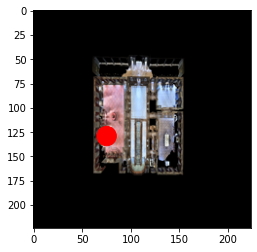

In [67]:
train_dataset.visualize_target(7)

In [20]:
train_dataset[0]['maps'][0].size()

torch.Size([3, 224, 224])

In [50]:
class CLIPLocator(nn.Module):
    def __init__(self, config):
        super(CLIPLocator, self).__init__()
        self.CLIP, _ = clip.load("RN50")
        self.config = config

        self.dropout = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048, 1024)
        self.regressionLinear = nn.Linear(1024, 2)
        self.floorClassificationLinear = nn.Linear(1024, 5)

    def forward(self, map, dialog):
        batch_size, num_maps, channels, height, width = map.size()
        map = map.view(batch_size * num_maps, channels, height, width)
        image_enc = self.CLIP.encode_image(map)
        text_enc = self.CLIP.encode_text(dialog)
        text_enc = torch.repeat_interleave(text_enc, num_maps, 0)
        enc = torch.cat((image_enc, text_enc), dim=-1)
        dropoutOut = self.dropout(enc)
        linear1Out = F.relu(self.linear1(dropoutOut))
        regressionOut = self.regressionLinear(linear1Out)
        floorclassificationOut = self.floorClassificationLinear(linear1Out)

        return regressionOut, floorclassificationOut 

In [ ]:
def train(train_loader, model, criterion, optimizer, scheduler, device, config):
    # Training 
    for idx, data in enumerate(tqdm(train_loader)):
        
        maps = data['maps'].to(device)
        conversations = data['conversations']
        
        regressionPreds, classificationPreds = model()
    

In [51]:
loc = CLIPLocator(config)

In [52]:
def main():

    # Load Data 


    # Define model, loss and optimizer 
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(loc.parameters())
    scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')

    # Run train and validation loop 


    # Run Test 


    # Save results 